## **Yelp Dataset Assignment**

This project delves into exploratory analysis and building predictive models using the [Yelp academic dataset](https://www.yelp.com/dataset_challenge/). It is an opportunity for you to explore machine learning tasks in the context of a real-world data set using big data analysis tools. In order to use the dataset and finish this project, you must agree to the dataset's terms of use provided [here](https://www.yelp.com/html/pdf/Dataset_Challenge_Academic_Dataset_Agreement.pdf).

We have chosen a subset of the Yelp academic dataset for you to work with. This subsampled data is loaded into RDDs in part (0). The complete dataset is available from Yelp's website [here](https://www.yelp.com/dataset_challenge/dataset).

#### ** This assignment will cover: **
*  *Part 1 (30 Points):* Exploratory Data Analysis [Link](https://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD) [Link](https://spark.apache.org/docs/2.2.0/api/python/pyspark.mllib.html#module-pyspark.mllib.stat)
*  *Part 2 (15 Points):* Prediction using tree ensemble methods [Link](https://spark.apache.org/docs/2.2.0/mllib-ensembles.html)
*  *Part 3 (20 Points):* Collaborative filtering for recommendation [Link](https://spark.apache.org/docs/2.2.0/mllib-collaborative-filtering.html)
*  *Part 4 (15 Points):* Topic modeling for text reviews [Link](https://spark.apache.org/docs/2.2.0/mllib-clustering.html#latent-dirichlet-allocation-lda)
*  *Part 5 (10 Points):* Word2Vec for text reviews [Link](https://spark.apache.org/docs/2.2.0/api/python/pyspark.mllib.html#pyspark.mllib.feature.Word2Vec)
*  *Part 6 (10 Points):* Frequent pattern mining using FP-Growth algorithm [Link](https://spark.apache.org/docs/2.2.0/mllib-frequent-pattern-mining.html)
*  *Part 7 (Bonus: 20 Points):* Any additional and insightful exploratory data analysis or machine learning tasks you want to do.

#### Note that, for reference, you can look up the details of the relevant Spark methods in [Spark's Python API](https://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD) and the relevant NumPy methods in the [NumPy Reference](http://docs.scipy.org/doc/numpy/reference/index.html)

### ** Code of Conduct **

** Please follow the following guidelines with respect to collaboration: **

* By using the dataset, you agree to Yelp's terms of use available [here](https://www.yelp.com/html/pdf/Dataset_Challenge_Academic_Dataset_Agreement.pdf).
* You are free to use the Web, APIs, ML toolkits, etc. in this project to your best benefit. Please cite any online or offline sources (even casual sources like StackOverflow) if you use them in the project.
* The assignment is to be done individually. No collaboration is allowed between students. No discussion is allowed about the project with anyone else except the class instructors.

# ** Part 0: Load the datasets required for the project **

We will load four datasets for this project. In addition to the four datasets, we will also load two lists which contain names by gender. These lists are helpful in assigning a gender to a Yelp user by their name, since gender is not available in the Yelp dataset.

Let's first start by creating the SparkContext.

In [1]:
import sys
sys.path.append("/opt/packages/spark/latest/python/lib/py4j-0.10.9-src.zip")
sys.path.append("/opt/packages/spark/latest/python/")
sys.path.append("/opt/packages/spark/latest/python/pyspark")
from pyspark.sql import SparkSession
spark = SparkSession.builder.master('local[*]').config("spark.driver.memory", "30g").getOrCreate()
sc = spark.sparkContext

23/05/01 21:57:34 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [2]:
import json
import os
import sys
import os.path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# helper function to load a JSON dataset from a publicly accessible url
def get_rdd_from_path(path):
    file_reader = open(path, 'r')
    str_contents = file_reader.readlines()
    json_contents = [json.loads(x.strip()) for x in str_contents]
    rdd = sc.parallelize(json_contents,  numSlices=2000)
    return rdd

The first dataset we are going to load is information about Yelp businesses. The information of each business will be stored as a Python dictionary within an RDD. The dictionary consists of the following fields:

* "business_id":"encrypted business id"
* "name":"business name"
* "neighborhood":"hood name"
* "address":"full address"
* "city":"city"
* "state":"state -- if applicable --"
* "postal code":"postal code"
* "latitude":latitude
* "longitude":longitude
* "stars":star rating, rounded to half-stars
* "review_count":number of reviews
* "is_open":0/1 (closed/open)
* "attributes":["an array of strings: each array element is an attribute"]
* "categories":["an array of strings of business categories"]
* "hours":["an array of strings of business hours"]
* "type": "business"

In [3]:
# load the data about Yelp businesses in an RDD
# each RDD element is a Python dictionary parsed from JSON using json.loads()
businesses_rdd = get_rdd_from_path('/ocean/projects/cis220071p/shared/data/yelp_academic_dataset_business.json')
print (businesses_rdd.count())
print (businesses_rdd.take(2))

61184
[{'business_id': 'vcNAWiLM4dR7D2nwwJ7nCA', 'full_address': '4840 E Indian School Rd\nSte 101\nPhoenix, AZ 85018', 'hours': {'Tuesday': {'close': '17:00', 'open': '08:00'}, 'Friday': {'close': '17:00', 'open': '08:00'}, 'Monday': {'close': '17:00', 'open': '08:00'}, 'Wednesday': {'close': '17:00', 'open': '08:00'}, 'Thursday': {'close': '17:00', 'open': '08:00'}}, 'open': True, 'categories': ['Doctors', 'Health & Medical'], 'city': 'Phoenix', 'review_count': 9, 'name': 'Eric Goldberg, MD', 'neighborhoods': [], 'longitude': -111.983758, 'state': 'AZ', 'stars': 3.5, 'latitude': 33.499313, 'attributes': {'By Appointment Only': True}, 'type': 'business'}, {'business_id': 'UsFtqoBl7naz8AVUBZMjQQ', 'full_address': '202 McClure St\nDravosburg, PA 15034', 'hours': {}, 'open': True, 'categories': ['Nightlife'], 'city': 'Dravosburg', 'review_count': 4, 'name': "Clancy's Pub", 'neighborhoods': [], 'longitude': -79.88693, 'state': 'PA', 'stars': 3.5, 'latitude': 40.350519, 'attributes': {'Hap

The second dataset we are going to load is information about Yelp users. Each user's information will be stored as a Python dictionary within an RDD. The dictionary consists of the following fields:

*  "user_id":"encrypted user id"
*  "name":"first name"
*  "review_count":number of reviews
*  "yelping_since": date formatted like "2009-12-19"
*  "friends":["an array of encrypted ids of friends"]
*  "useful":"number of useful votes sent by the user"
*  "funny":"number of funny votes sent by the user"
*  "cool":"number of cool votes sent by the user"
*  "fans":"number of fans the user has"
*  "elite":["an array of years the user was elite"]
*  "average_stars":floating point average like 4.31
*  "compliment_hot":number of hot compliments received by the user
*  "compliment_more":number of more compliments received by the user
*  "compliment_profile": number of profile compliments received by the user
*  "compliment_cute": number of cute compliments received by the user
*  "compliment_list": number of list compliments received by the user
*  "compliment_note": number of note compliments received by the user
*  "compliment_plain": number of plain compliments received by the user
*  "compliment_cool": number of cool compliments received by the user
*  "compliment_funny": number of funny compliments received by the user
*  "compliment_writer": number of writer compliments received by the user
*  "compliment_photos": number of photo compliments received by the user
*  "type":"user"

In [4]:
# load the data about Yelp users in an RDD
# each RDD element is a Python dictionary parsed from JSON using json.loads()
users_rdd = get_rdd_from_path('/ocean/projects/cis220071p/shared/data/yelp_academic_dataset_user.json')
print (users_rdd.count())
print (users_rdd.take(2))

366715
[{'yelping_since': '2004-10', 'votes': {'funny': 166, 'useful': 278, 'cool': 245}, 'review_count': 108, 'name': 'Russel', 'user_id': '18kPq7GPye-YQ3LyKyAZPw', 'friends': ['rpOyqD_893cqmDAtJLbdog', '4U9kSBLuBDU391x6bxU-YA', 'fHtTaujcyKvXglE33Z5yIw', '8J4IIYcqBlFch8T90N923A', 'wy6l_zUo7SN0qrvNRWgySw', 'HDQixQ-WZEV0LVPJlIGQeQ', 'T4kuUr_iJiywOPdyM7gTHQ', 'z_5D4XEIlGAPjG3Os9ix5A', 'i63u3SdbrLsP4FxiSKP0Zw', 'pnrGw4ciBXJ6U5QB2m0F5g', 'ytjCBxosVSqCOQ62c4KAxg', 'r5uiIxwJ-I-oHBkNY2Ha3Q', 'niWoSKswEbooJC_M7HMbGw', 'kwoxiKMyoYjB1wTCYAjYRg', '9A8OuP6XwLwnNb9ov3_Ncw', '27MmRg8LfbZXNEHkEnKSdA', 'Bn4sJUTtKFZQt0FKHF2Adw', 'uguXfIEpI65jSCH5MgUDgA', '6VZNGc2h2Bn-uyuEXgOt5g', 'AZ8CTtwr-4sGM2kZqF6qig', 'S742m-AuQicMSLDdErrLZQ', 'uGmQ6ab4iVpWn5m61VFhkQ', 'GJYJX4SujVj3BR8v2F9PDQ', '3shjifK-vZkIHciyy_KbYA', '4lc_H2Cf7CO0tCgyA3aSVQ', 'Tunkp_F1R_uFBJQTsDxD4g', 'B9pKfr27czBbCoAIircZdQ', 'pePGMO6EbDpbaZ7D2m6HIg', 'XRM8W6HUoXbrYKR3BCj9Rg', '8DqIWXsKXOipfduYEfFpNw', 'dvRVX54Z9f7Om51NsTRX1w', 'CM0saLQmk4oAB17

The third dataset we are going to load is information about business checkins reported by users on Yelp. Each checkin's information will be stored as a Python dictionary within an RDD. The dictionary consists of the following fields:

*  "checkin_info":["an array of check ins with the format day-hour:number of check ins from hour to hour+1"]
*  "business_id":"encrypted business id"
*  "type":"checkin"

In [5]:
# load the data about business checkins reported by users on Yelp in an RDD
# each RDD element is a Python dictionary parsed from JSON using json.loads()
checkins_rdd = get_rdd_from_path('/ocean/projects/cis220071p/shared/data/yelp_academic_dataset_checkin.json')
print (checkins_rdd.count())
print (checkins_rdd.take(2))

45166
[{'checkin_info': {'9-5': 1, '7-5': 1, '13-3': 1, '17-6': 1, '13-0': 1, '17-3': 1, '10-0': 1, '18-4': 1, '14-6': 1}, 'type': 'checkin', 'business_id': 'cE27W9VPgO88Qxe4ol6y_g'}, {'checkin_info': {'22-5': 1, '9-5': 1, '15-1': 1, '15-4': 1, '16-2': 1, '21-4': 1, '13-1': 1, '14-4': 1, '12-5': 1, '12-1': 1}, 'type': 'checkin', 'business_id': 'mVHrayjG3uZ_RLHkLj-AMg'}]


The fourth dataset we are going to load is information about business reviews written by users on Yelp. Each review's data will be stored as a Python dictionary within an RDD. The dictionary consists of the following fields:

*  "review_id":"encrypted review id"
*  "user_id":"encrypted user id"
*  "business_id":"encrypted business id"
*  "stars":star rating rounded to half-stars
*  "date":"date formatted like 2009-12-19"
*  "text":"review text"
*  "useful":number of useful votes received
*  "funny":number of funny votes received
*  "cool": number of cool review votes received
*  "type": "review"

In [6]:
# load the data about business reviews written by users on Yelp in an RDD, limited to businesses in Pittsburgh due to DataBricks computational limits
# each RDD element is a Python dictionary parsed from JSON using json.loads()
reviews_rdd = get_rdd_from_path('/ocean/projects/cis220071p/shared/data/yelp_academic_dataset_review_pittsburgh.json')
print (reviews_rdd.count())
print (reviews_rdd.take(2))

62608
[{'votes': {'funny': 3, 'useful': 7, 'cool': 7}, 'user_id': 'JbAeIYc89Sk8SWmrBCJs9g', 'review_id': 'fBQ69-NU9ZyTjjS7Tb5tww', 'stars': 5, 'date': '2013-06-10', 'text': "THANK YOU ROB! i truly appreciated all the help i received from this agent today who was able to removed the extra charges on my bill that the Pasadena Verizon Store on Lake was charging me on my bill for upgrading my phone.   When i went in i was having problems with my Blacberry and had to switch to the Iphone last week. Rob from the Pennsylvania store who i was connected today was able to look at my bill and all the notes and correct the problem immediately. Great Customer Service! He even set up a FOLLOW UP Phone Call with me On July 5th to make sure the credit goes through on my bill...I can't thank him enough!!!!", 'type': 'review', 'business_id': 'HZdLhv6COCleJMo7nPl-RA'}, {'votes': {'funny': 1, 'useful': 1, 'cool': 1}, 'user_id': 'l_szjd-ken3ma6oHDkTYXg', 'review_id': 'CFiLh7WvH7dM3qVZvNiacQ', 'stars': 2, '

Finally, we will load two lists. The first list consists of male names, and the second list consists of female names, to map Yelp user names to gender.

In [7]:
# helper function to load a list of names from a publicly accessible url
def get_names_from_path(path):
    file_reader = open(path, 'r')
    str_contents = file_reader.readlines()
    str_contents = [x.strip() for x in str_contents]
    result = str_contents[6:]
    return result

male_names = get_names_from_path('/ocean/projects/cis220071p/shared/data/male.txt')
print('First five male names: ', male_names[:5])
print('Number of male names: ', len(male_names))

female_names = get_names_from_path('/ocean/projects/cis220071p/shared/data/female.txt')
print('First five female names: ', female_names[:5])
print('Number of female names: ', len(female_names))

First five male names:  ['Aamir', 'Aaron', 'Abbey', 'Abbie', 'Abbot']
Number of male names:  2943
First five female names:  ['Abagael', 'Abagail', 'Abbe', 'Abbey', 'Abbi']
Number of female names:  5001


# ** Part 1: Exploratory Data Analysis **

Performing some exploratory analysis is a great step toward understanding the data before building any statistical machine learning models on it.

Please replace `<FILL IN>` with your solution. This is the general form that exercises will take. Exercises will include an explanation of what is expected, followed by code cells where one cell will have one or more `<FILL IN>` sections.  The cell that needs to be modified will have `# TODO: Replace <FILL IN> with appropriate code` on its first line.

In [8]:
print ('Number of businesses: ', businesses_rdd.count())
print ('Number of users: ', users_rdd.count())
print ('Number of checkins: ', checkins_rdd.count())
print ('Number of reviews: ', reviews_rdd.count())

Number of businesses:  61184
Number of users:  366715


Number of checkins:  45166


Number of reviews:  62608


** Question1: ** Print the top 5 business categories by frequency and the number of times they appear in the businesses data.

In [9]:
# TODO: Replace <FILL IN>
from operator import add

top5_categories = businesses_rdd.flatMap(lambda x:x['categories']).map(lambda x:(x,1)).reduceByKey(add).sortBy(lambda x:-x[1]).take(5)
print('Top 5 business categories and times they appear: ', top5_categories)

Top 5 business categories and times they appear:  [('Restaurants', 21892), ('Shopping', 8919), ('Food', 7862), ('Beauty & Spas', 4738), ('Nightlife', 4340)]


** Question2: ** Print the top 5 cities by frequency and the number of times they appear in the businesses data.

In [10]:
# TODO: Replace <FILL IN>

top5_cities = businesses_rdd.map(lambda x:(x['city'],1)).reduceByKey(add).sortBy(lambda x:-x[1]).take(5)
print('Top 5 cities and times they appear: ', top5_cities)

Top 5 cities and times they appear:  [('Las Vegas', 13601), ('Phoenix', 8410), ('Charlotte', 4224), ('Scottsdale', 4039), ('Edinburgh', 3031)]


** Question3: ** Plot the histogram of stars received by businesses.

Text(0, 0.5, 'Number of Businesses')

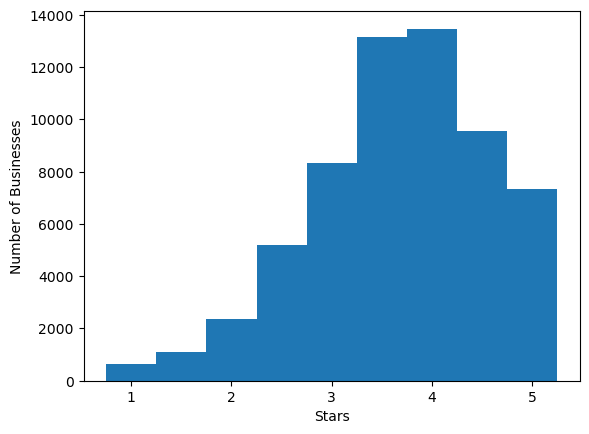

In [11]:
# TODO: Replace <FILL IN>

businesses_stars_counts = businesses_rdd.map(lambda x:x['stars']).collect()
plt.hist(businesses_stars_counts, bins=[x/2-0.25 for x in range(2, 12)])
plt.xlabel('Stars')
plt.ylabel('Number of Businesses')

** Question4: ** Plot the histogram of number of reviews received by businesses.

Text(0, 0.5, 'Number of Businesses')

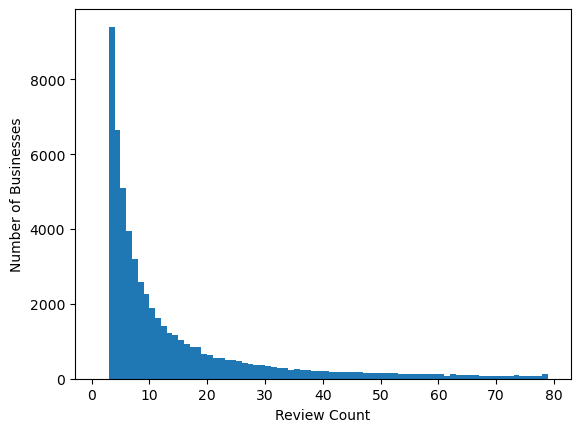

In [12]:
# TODO: Replace <FILL IN>

businesses_review_counts = businesses_rdd.map(lambda x:x['review_count']).collect()

plt.hist(businesses_review_counts, bins=range(1,80))
plt.xlabel('Review Count')
plt.ylabel('Number of Businesses')

** Question5: ** Plot the above histogram but now on a log-log scale using `bins=range(1,1000)`. Do you see a [Power Law](https://en.wikipedia.org/wiki/Power_law) relationship in the plot? Explain your answer.

** Answer: ** Yes. The log-log hist plot shows a near linear relationship between log review count and log number of businesses. Therefore, the number of businessnes for each review count can be represented by the power of the count. 

Text(0, 0.5, 'Number of Businesses')

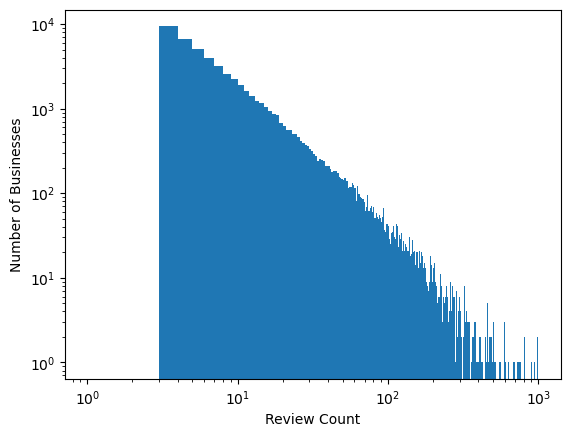

In [17]:
# TODO: Replace <FILL IN>

plt.hist(businesses_review_counts, bins=range(1,1000),log=True)
plt.gca().set_xscale("log")

plt.xlabel('Review Count')
plt.ylabel('Number of Businesses')

** Question6: ** Plot the histogram of number of reviews written by users.

Text(0, 0.5, 'Number of Users')

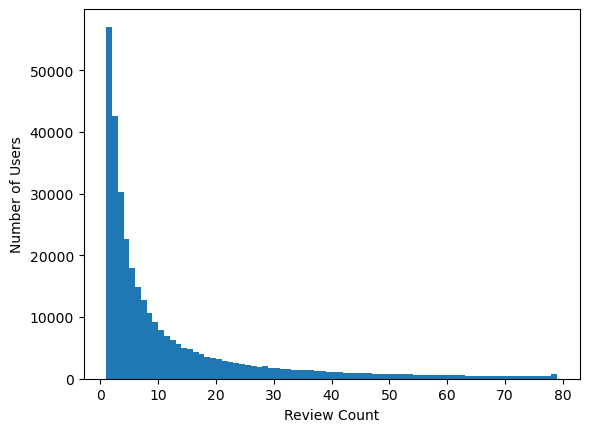

In [16]:
# TODO: Replace <FILL IN>

users_review_counts = users_rdd.map(lambda x:x['review_count']).collect()

plt.hist(users_review_counts, bins=range(1,80))
plt.xlabel('Review Count')
plt.ylabel('Number of Users')

** Question7: ** Plot the above histogram but now on a log-log scale using `bins=range(1,1000)`. Do you see a [Power Law](https://en.wikipedia.org/wiki/Power_law) relationship in the plot? Explain your answer.

** Answer: ** Yes. The log-log hist plot shows a near linear relationship between log review count and log number of users. Therefore, the number of users for each review count can be represented by the power of the count. 

Text(0, 0.5, 'Number of Users')

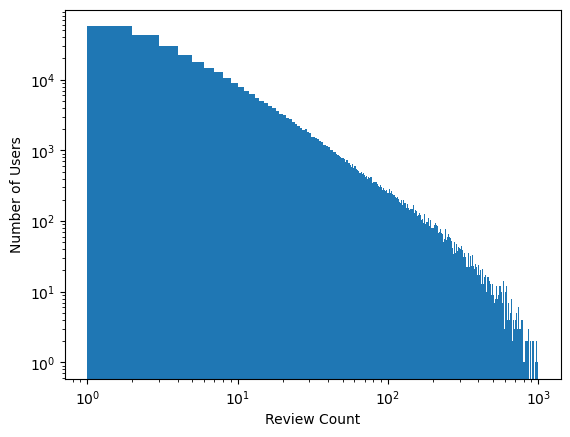

In [19]:
# TODO: Replace <FILL IN>
plt.hist(users_review_counts, bins=range(1,1000),log=True)
plt.gca().set_xscale("log")

plt.xlabel('Review Count')
plt.ylabel('Number of Users')

** Question8: ** Plot the histogram of number of friends a Yelp user has.

Text(0, 0.5, 'Number of Users')

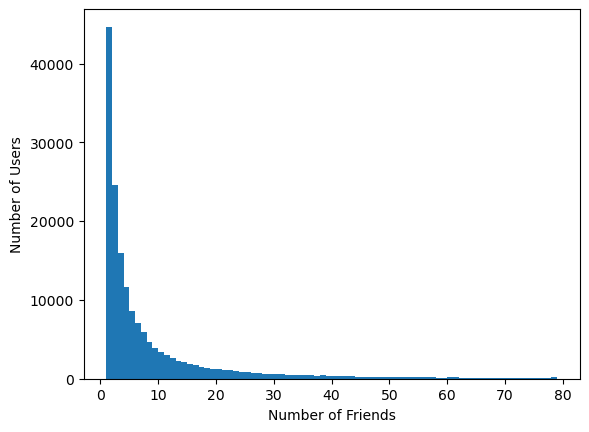

In [20]:
# TODO: Replace <FILL IN>

user_friend_counts = users_rdd.map(lambda x:len(x['friends'])).collect()

plt.hist(user_friend_counts, bins=range(1,80))
plt.xlabel('Number of Friends')
plt.ylabel('Number of Users')

** Question9: ** Plot the above histogram but now on a log-log scale. Do you see a [Power Law](https://en.wikipedia.org/wiki/Power_law) relationship in the plot? Explain your answer.

** Answer: ** Yes. The log-log hist plot shows a near linear relationship between log number of users and log number of friends. Therefore, the number of users for each friend count can be represented by the power of the friend count.

Text(0, 0.5, 'Number of Users')

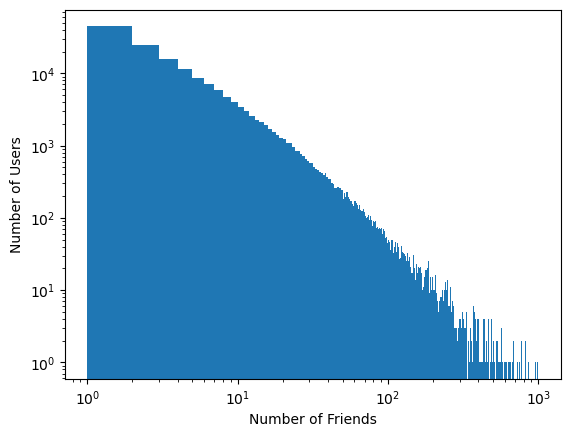

In [21]:
# TODO: Replace <FILL IN>

plt.hist(user_friend_counts, bins=range(1,1000),log=True)
plt.gca().set_xscale("log")

plt.xlabel('Number of Friends')
plt.ylabel('Number of Users')

** Question10: ** Plot the histogram of number of fans a Yelp user has.

Text(0, 0.5, 'Number of Users')

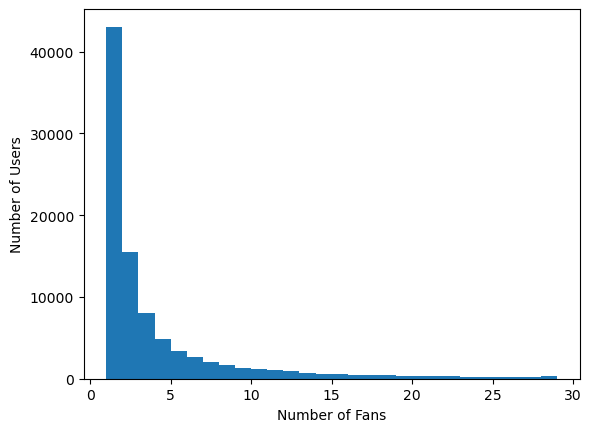

In [22]:
# TODO: Replace <FILL IN>

users_fan_counts = users_rdd.map(lambda x:x['fans']).collect()

plt.hist(users_fan_counts, bins=range(1,30))
plt.xlabel('Number of Fans')
plt.ylabel('Number of Users')

** Question11: ** Plot the above histogram but now on a log-log scale. Do you see a [Power Law](https://en.wikipedia.org/wiki/Power_law) relationship in the plot? Explain your answer.

** Answer: ** Yes. The log-log hist plot shows a near linear relationship between log number of users and log number of fans. Therefore, the number of users for each fans count can be represented by the power of the fans count.

Text(0, 0.5, 'Number of Users')

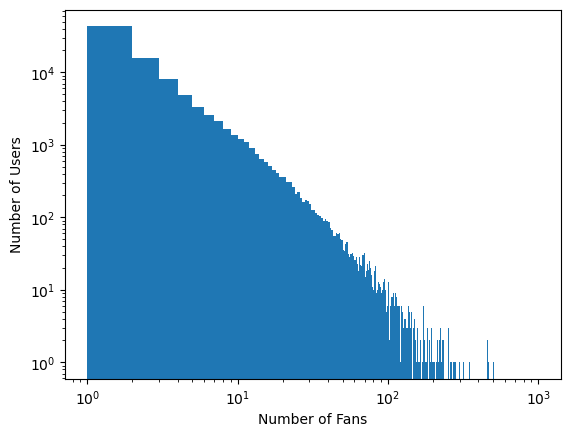

In [26]:
# TODO: Replace <FILL IN>

plt.hist(users_fan_counts, bins=range(1,1000),log=True)
plt.gca().set_xscale("log")

plt.xlabel('Number of Fans')
plt.ylabel('Number of Users')

** Question12: ** Plot the histogram of number of checkins per Yelp business.

Text(0, 0.5, 'Number of Businesses')

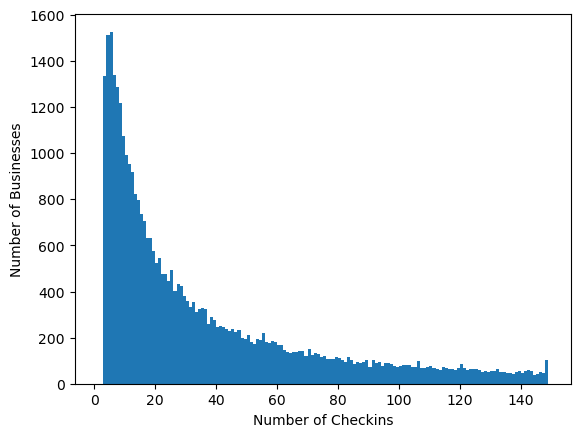

In [24]:
# TODO: Replace <FILL IN>

business_checkin_counts = checkins_rdd.map(lambda x:sum(x['checkin_info'].values())).collect()

plt.hist(business_checkin_counts, bins=range(1,150))
plt.xlabel('Number of Checkins')
plt.ylabel('Number of Businesses')

** Question13: ** Plot the above histogram but now on a log-log scale using `bins=range(3,200)`. Do you see a [Power Law](https://en.wikipedia.org/wiki/Power_law) relationship in the plot? Explain your answer.

** Answer: ** No. Because the log-log plot is not in linear shape. It has a spike at the end.

Text(0, 0.5, 'Number of Businesses')

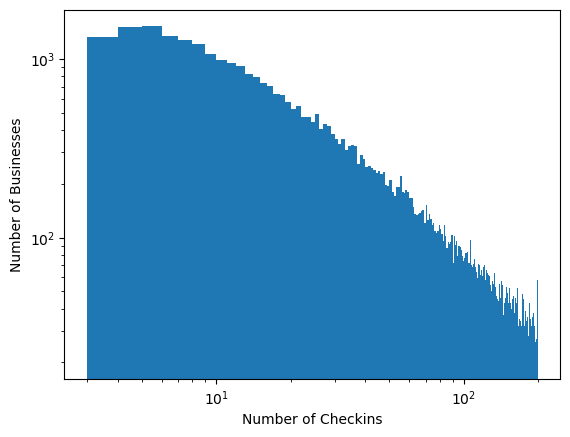

In [27]:
# TODO: Replace <FILL IN>

plt.hist(business_checkin_counts, bins=range(3,200),log=True)
plt.gca().set_xscale("log")

plt.xlabel('Number of Checkins')
plt.ylabel('Number of Businesses')

** Question14: ** Find the maximum value of checkins per business. Filter to obtain business IDs of businesses that had these maximum number of checkins. Fill in the code required to carry out these steps.

In [41]:
# TODO: Replace <FILL IN>

max_checkin_count = checkins_rdd.map(lambda x:len(x['checkin_info'])).max()
business_ids_with_max_checkins = checkins_rdd \
    .filter(lambda x:len(x['checkin_info'])==max_checkin_count) \
    .map(lambda x:x['business_id']).collect()
len(business_ids_with_max_checkins)

41

In [42]:
# TODO: Replace <FILL IN>

business_names_with_max_checkins = businesses_rdd \
    .filter(lambda x: x['business_id'] in business_ids_with_max_checkins) \
    .map(lambda x: (x['name'], x['city'])).collect()
business_names_with_max_checkins

[('Charlotte Douglas International Airport', 'Charlotte'),
 ('Phoenix Sky Harbor International Airport', 'Phoenix'),
 ('Pho Kim Long', 'Las Vegas'),
 ('McCarran International Airport', 'Las Vegas'),
 ('The California Hotel & Casino', 'Las Vegas'),
 ('Golden Nugget Hotel & Casino', 'Las Vegas'),
 ('Rio All Suites Hotel & Casino', 'Las Vegas'),
 ('24 Hour Fitness', 'Las Vegas'),
 ('Excalibur Hotel', 'Las Vegas'),
 ('Ellis Island Casino & Brewery', 'Las Vegas'),
 ('Las Vegas Athletic Club', 'Las Vegas'),
 ('Orleans Hotel & Casino', 'Las Vegas'),
 ('Palms Casino Resort', 'Las Vegas'),
 ('Bellagio Hotel', 'Las Vegas'),
 ('New York - New York', 'Las Vegas'),
 ('Paris Las Vegas Hotel & Casino', 'Las Vegas'),
 ('Monte Carlo Hotel And Casino', 'Las Vegas'),
 ('The Venetian Resort Hotel Casino', 'Las Vegas'),
 ('The Mirage', 'Las Vegas'),
 ('MGM Grand Hotel', 'Las Vegas'),
 ('Treasure Island, LLC', 'Las Vegas'),
 ('The Peppermill Restaurant & Fireside Lounge', 'Las Vegas'),
 ('Flamingo Las Vegas

** Question15: ** Why do you think the above list sees much higher checkins than other businesses in the dataset?

** Answer: ** Las Vegas is the city that appeared most for the businesses with higher checkins. Therefore, location maybe a factor that leads to higher checkins. Also, airports, hotels, clubs and cafes see much higher checkins. Maybe people are more willing to share when they are on vacations or enjoying foods.



** Question16: ** Plot a histogram of the stars associated with business reviews.

Text(0, 0.5, 'Number of Reviews')

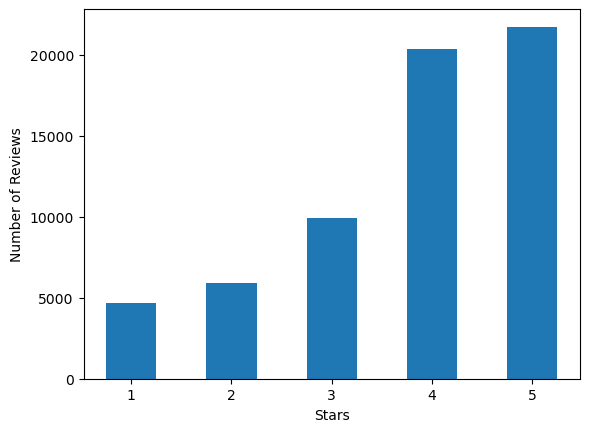

In [44]:
# TODO: Replace <FILL IN>

review_stars_counts = reviews_rdd.map(lambda x:x['stars']).collect()
plt.hist(review_stars_counts, bins=[x/2-0.25 for x in range(2, 12)])
plt.xlabel('Stars')
plt.ylabel('Number of Reviews')

** Question17: ** Plot a histogram of the number of reviews written per Yelp user.

Text(0, 0.5, 'Number of Users')

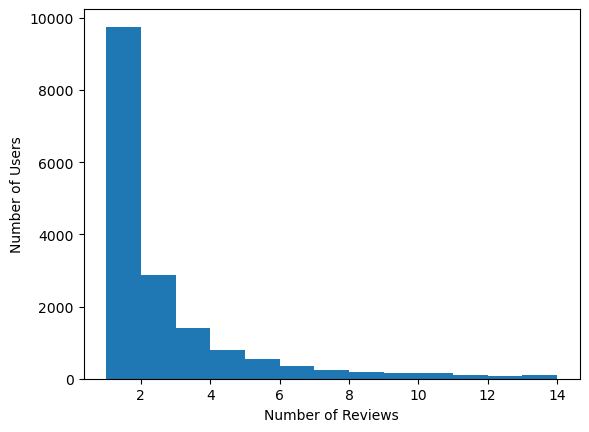

In [47]:
# TODO: Replace <FILL IN>

user_review_counts = list(reviews_rdd.map(lambda x:x['user_id']).countByValue().values())

plt.hist(user_review_counts, bins=[x for x in range(1, 15)])
plt.xlabel('Number of Reviews')
plt.ylabel('Number of Users')

** Question18: ** Plot a histogram of the number of reviews written per Yelp business.

Text(0, 0.5, 'Number of Businesses')

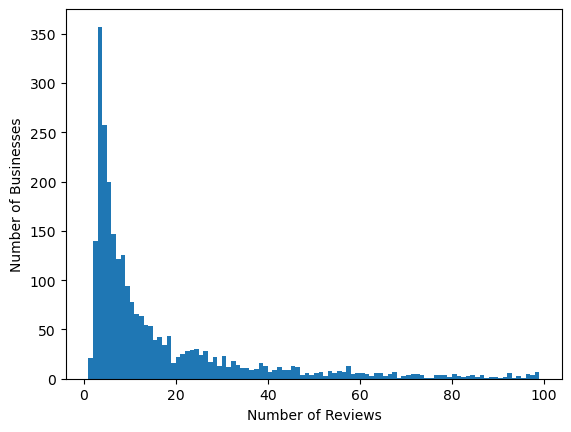

In [48]:
# TODO: Replace <FILL IN>

business_review_counts = list(reviews_rdd.map(lambda x:x['business_id']).countByValue().values())

plt.hist(business_review_counts, bins=[x for x in range(1, 100)])
plt.xlabel('Number of Reviews')
plt.ylabel('Number of Businesses')

** Question19: ** Plot a histogram of the number of useful votes received by Yelp reviews.

Text(0, 0.5, 'Number of Reviews')

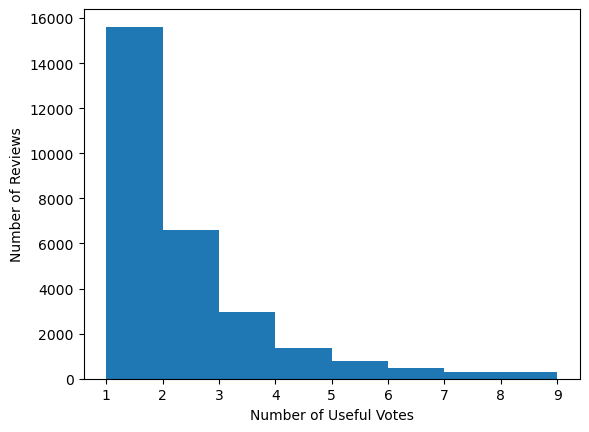

In [49]:
# TODO: Replace <FILL IN>

review_useful_counts = reviews_rdd.map(lambda x:x['votes']['useful']).collect()

plt.hist(review_useful_counts, bins=[x for x in range(1, 10)])
plt.xlabel('Number of Useful Votes')
plt.ylabel('Number of Reviews')

** Question20: ** Plot a histogram of the number of funny votes received by Yelp reviews.

Text(0, 0.5, 'Number of Reviews')

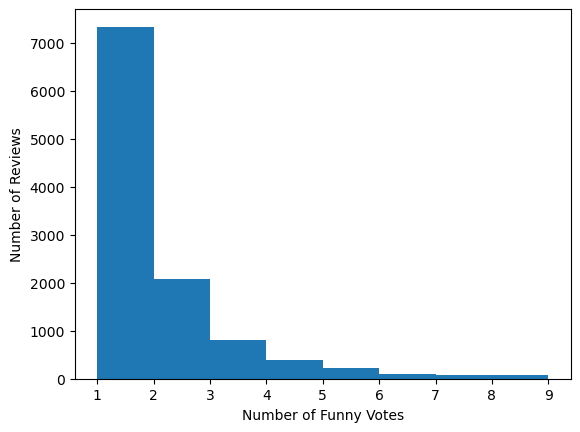

In [50]:
# TODO: Replace <FILL IN>

review_funny_counts = reviews_rdd.map(lambda x:x['votes']['funny']).collect()

plt.hist(review_funny_counts, bins=[x for x in range(1, 10)])
plt.xlabel('Number of Funny Votes')
plt.ylabel('Number of Reviews')

** Question21: ** Plot a histogram of the number of cool votes received by Yelp reviews.

Text(0, 0.5, 'Number of Reviews')

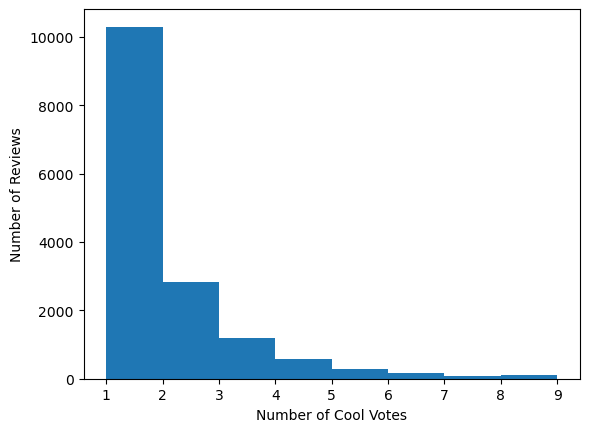

In [51]:
# TODO: Replace <FILL IN>

review_cool_counts = reviews_rdd.map(lambda x:x['votes']['cool']).collect()

plt.hist(review_cool_counts, bins=[x for x in range(1, 10)])
plt.xlabel('Number of Cool Votes')
plt.ylabel('Number of Reviews')

** Question22: ** Plot a pair-plot of the number of useful, funny, and cool votes received by Yelp reviews alongwith the stars associated with the review and the length of the review.

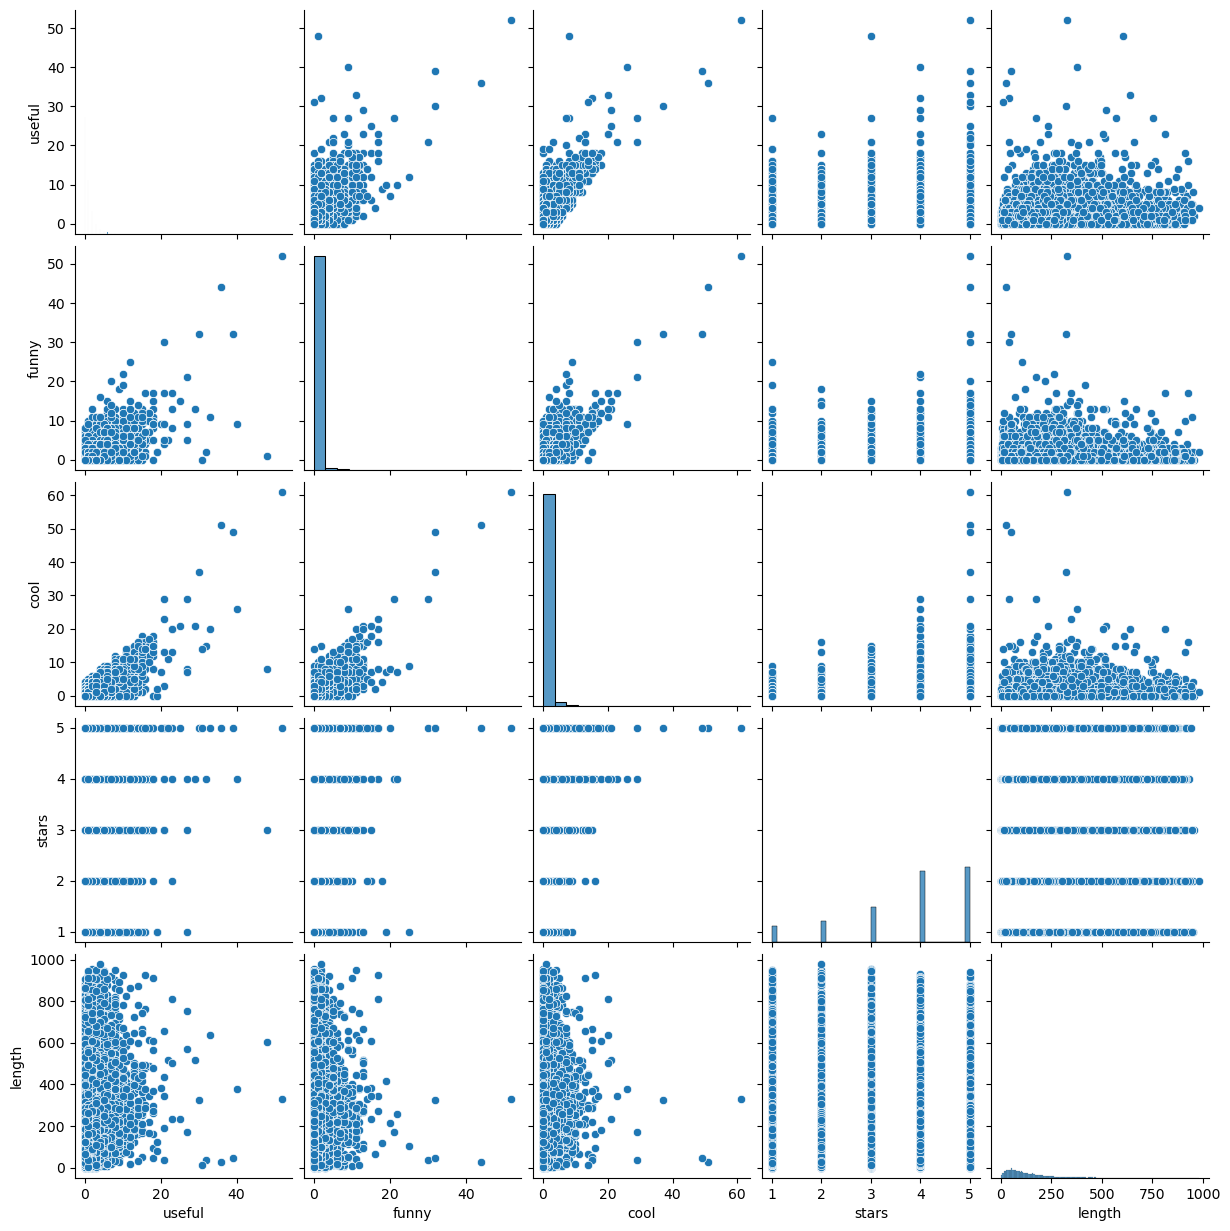

In [57]:
# TODO: Replace <FILL IN>

review_votes_length = reviews_rdd.map(lambda x:(x['votes']['useful'],x['votes']['funny'], x['votes']['cool'],\
                                                x['stars'],len(x['text'].split()))).collect()
review_votes_length_df = pd.DataFrame(review_votes_length, columns=['useful', 'funny', 'cool', 'stars', 'length'])
sns.pairplot(review_votes_length_df)

** Question23: ** Let us plot the distribution of the number of words used by males and females in their reviews. We will use the lists "male_names" and "female_names" we had created earlier for this purpose. Let's first find the user IDs associated with males and females.

In [58]:
# TODO: Replace <FILL IN>

male_users = users_rdd.filter(lambda x:x['name'] in male_names)
female_users = users_rdd.filter(lambda x:x['name'] in female_names)

male_user_ids = male_users.map(lambda x:x['user_id']).collect()
female_user_ids = female_users.map(lambda x:x['user_id']).collect()

print (len(male_user_ids))
print (len(female_user_ids))
print (users_rdd.count())

166682
174869


366715


** Question24: ** We can now use the user ID lists to separate the reviews into those by males and females and calculate the length of each review.

In [59]:
# TODO: Replace <FILL IN>

male_reviews = reviews_rdd.filter(lambda x:x['user_id'] in male_user_ids).map(lambda x : x['text'])
female_reviews = reviews_rdd.filter(lambda x:x['user_id'] in female_user_ids).map(lambda x : x['text'])

male_word_count = male_reviews.map(lambda x:len(x.split()))
female_word_count = female_reviews.map(lambda x:len(x.split()))

print ('Male and female review length averages: ', male_word_count.mean(), female_word_count.mean())

Male and female review length averages:  127.3470787972136 139.21062276751053


** Question25: ** The code below calculates the distributions of review lengths for males and female reviewers and plots them. Do you see a marked difference between the average review length of male and female reviewers? Are there any major trends or differences between the distributions of review length of male and female reviewers?

** Answer: ** Generally the distribution looks similar. But females tend to have larger average review length than males. The females review length distribution is a bit higher than males with a fat tail in the right end, which means there are more reviews for females that have more words.

In [60]:
male_word_distribution = list(male_word_count.map(lambda x : (x,1)).countByKey().items())
female_word_distribution = list(female_word_count.map(lambda x : (x,1)).countByKey().items())

male_word_distribution = sorted(male_word_distribution, key=lambda x: x[0])
female_word_distribution = sorted(female_word_distribution, key=lambda x: x[0])

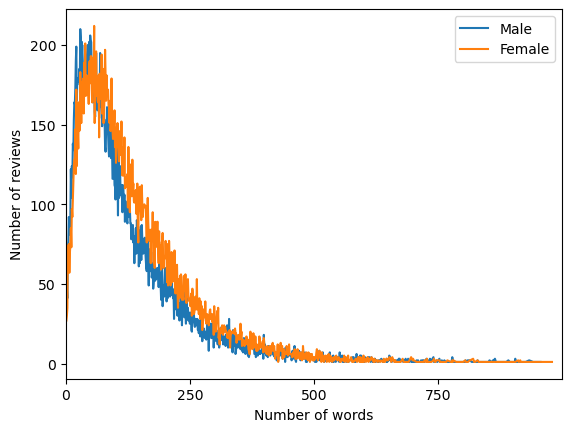

In [61]:
fig, ax = plt.subplots()
ax.plot([x[0] for x in male_word_distribution], [x[1] for x in male_word_distribution], label = 'Male')
ax.plot([x[0] for x in female_word_distribution], [x[1] for x in female_word_distribution], label = 'Female')

ax.set_xlim((0, 1000))
ax.set_xticks([0, 250, 500, 750])
ax.set_xticklabels(['0', '250','500','750'])

plt.xlabel('Number of words')
plt.ylabel('Number of reviews')
plt.legend()

# ** Part 2: Classification using tree ensemble methods **

In this section, we will predict the number of funny votes that a review has earned, indicating how funny readers found the review.

In [10]:
from pyspark.mllib.tree import DecisionTree, DecisionTreeModel
from pyspark.mllib.tree import RandomForest, RandomForestModel
from pyspark.mllib.tree import GradientBoostedTrees, GradientBoostedTreesModel
from pyspark.mllib.linalg import Vectors, DenseVector, SparseVector
from pyspark.mllib.regression import LabeledPoint

** Question1: ** Fill in the necessary code to calculate word counts from text reviews below.

In [11]:
# TODO: Replace <FILL IN>

max_words = 50000

all_reviews = reviews_rdd.map(lambda x : (x['text'], x['votes']['funny']))
word_counts = list(all_reviews.flatMap(lambda x: x[0].split()).map(lambda x: (x,1)).countByKey().items())
word_counts = sorted(word_counts, key=lambda x: -x[1])

unique_words = [x[0] for x in word_counts[:max_words]]
num_unique_words = len(unique_words)
print('Number of unique words: ', num_unique_words)

Number of unique words:  50000


** Question2: ** We will now construct two dictionaries - one which maps from each word to a unique integer index and the second one which maps back from the index to the word. Write the code required to do this.

In [12]:
# TODO: Replace <FILL IN>

word_to_index_dict = {unique_words[i]:i for i in range(len(unique_words))}
index_to_word_dict = {i:unique_words[i] for i in range(len(unique_words))}

** Question3: ** Fill in the required code below to obtain a LabeledPoint RDD that can be used to train an mllib classifier/regressor.

In [13]:
# TODO: Replace <FILL IN>
from collections import Counter

doc_vectors = all_reviews.map(lambda x: (x[1], x[0].split())).map(lambda x: (x[0], [word_to_index_dict[w] for w in x[1] if w in word_to_index_dict]))
doc_vectors = doc_vectors.map(lambda x: LabeledPoint(x[0],SparseVector(num_unique_words,dict(Counter(x[1])))))
print(doc_vectors.count())
print(doc_vectors.take(2))

62608
[LabeledPoint(3.0, (50000,[0,1,2,4,6,8,9,12,13,15,16,19,20,25,38,42,49,58,86,107,114,125,164,168,189,204,208,233,297,301,344,352,364,365,465,471,490,669,684,767,781,942,1003,1014,1106,1148,1360,1912,2283,2414,2960,3413,3958,4179,4356,4423,4779,4806,4968,5327,5743,6021,6022,6057,6268,9594,14463,14848,15307,16821,16822,17427,26734,31088,31089,37871],[8.0,3.0,1.0,5.0,5.0,1.0,1.0,1.0,2.0,4.0,6.0,1.0,1.0,1.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,5.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0])), LabeledPoint(1.0, (50000,[0,4,5,8,9,17,19,35,36,41,45,55,71,77,87,99,101,132,201,239,306,316,326,331,364,367,377,446,471,607,610,649,914,939,994,2960,3542,6587,6709,10548,15761,18035,20358],[2.0,3.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,

** Question4: ** Randomly split the doc_vectors RDD into 80% training and 20% validation data.

In [14]:
# TODO: Replace <FILL IN>

doc_vectors_train, doc_vectors_val = doc_vectors.randomSplit([0.8,0.2])

** Question5: ** Let us implement the baseline predictor which always outputs the most common value of funny votes. Fill in appropriate code.

In [13]:
# TODO: Replace <FILL IN>
from operator import add

most_common_prediction = doc_vectors_train.map(lambda x:(x.label,1)).reduceByKey(add).sortBy(lambda x:-x[1]).first()[0]

labels_and_predictions = doc_vectors_val.map(lambda lp: (lp.label, most_common_prediction))
val_mse = labels_and_predictions.map(lambda lp: (lp[0] - lp[1]) * (lp[0] - lp[1])).sum() /\
    float(doc_vectors_val.count())
print('Validation Root Mean Squared Error (Baseline) = ' + str(val_mse))
print('Learned baseline prediction: ', most_common_prediction)

Validation Root Mean Squared Error (Baseline) = 1.1011581760751599
Learned baseline prediction:  0.0


** Question6: ** Let us now use a Decision Tree to predict the number of funny votes. Set the maximum depth of the tree to 5 and use an appropriate impurity metric for regression.

In [16]:
# TODO: Replace <FILL IN>

dt_model = DecisionTree.trainRegressor(doc_vectors_train,categoricalFeaturesInfo = {}, impurity='variance',maxDepth=5)

predictions = dt_model.predict(doc_vectors_val.map(lambda x: x.features))
labels_and_predictions = doc_vectors_val.map(lambda lp: lp.label).zip(predictions)
val_mse = labels_and_predictions.map(lambda lp: (lp[0] - lp[1]) * (lp[0] - lp[1])).sum() /\
    float(doc_vectors_val.count())
print('Validation Root Mean Squared Error (Decision Tree) = ' + str(val_mse))
print('Learned regression tree model:')
print(dt_model.toDebugString())

23/04/30 21:25:24 WARN DAGScheduler: Broadcasting large task binary with size 1150.2 KiB
23/04/30 21:25:35 WARN DAGScheduler: Broadcasting large task binary with size 1923.4 KiB
23/04/30 21:25:46 WARN DAGScheduler: Broadcasting large task binary with size 1924.2 KiB
23/04/30 21:25:58 WARN DAGScheduler: Broadcasting large task binary with size 1924.8 KiB
23/04/30 21:26:10 WARN DAGScheduler: Broadcasting large task binary with size 1925.6 KiB
23/04/30 21:26:21 WARN DAGScheduler: Broadcasting large task binary with size 1926.4 KiB
23/04/30 21:26:33 WARN DAGScheduler: Broadcasting large task binary with size 1282.5 KiB


Validation Root Mean Squared Error (Decision Tree) = 0.8649342020248075
Learned regression tree model:
DecisionTreeModel regressor of depth 5 with 25 nodes
  If (feature 24056 <= 1.5)
   If (feature 3 <= 5.5)
    If (feature 44030 <= 0.5)
     If (feature 39660 <= 0.5)
      If (feature 38663 <= 0.5)
       Predict: 0.23276445380046612
      Else (feature 38663 > 0.5)
       Predict: 15.0
     Else (feature 39660 > 0.5)
      Predict: 13.0
    Else (feature 44030 > 0.5)
     Predict: 32.0
   Else (feature 3 > 5.5)
    If (feature 6896 <= 2.5)
     If (feature 9644 <= 1.5)
      If (feature 17 <= 2.5)
       Predict: 0.5245145631067961
      Else (feature 17 > 2.5)
       Predict: 0.9004149377593361
     Else (feature 9644 > 1.5)
      If (feature 1 <= 29.5)
       Predict: 17.0
      Else (feature 1 > 29.5)
       Predict: 10.0
    Else (feature 6896 > 2.5)
     If (feature 0 <= 12.5)
      Predict: 32.0
     Else (feature 0 > 12.5)
      Predict: 17.0
  Else (feature 24056 > 1.5)
   I

** Question7: ** Let us now use a Random Forest ensemble to predict the number of funny votes. Set the maximum depth of the tree to 5 and use an appropriate impurity metric for regression. Build a random forest regressor with 10 trees.

In [15]:
# TODO: Replace <FILL IN>

rf_model = RandomForest.trainRegressor(doc_vectors_train, categoricalFeaturesInfo={}, maxDepth=5, numTrees=10, impurity='variance')

predictions = rf_model.predict(doc_vectors_val.map(lambda x: x.features))
labels_and_predictions = doc_vectors_val.map(lambda lp: lp.label).zip(predictions)
val_mse = labels_and_predictions.map(lambda lp: (lp[0] - lp[1]) * (lp[0] - lp[1])).sum() /\
    float(doc_vectors_val.count())
print('Validation Root Mean Squared Error (Random Forest) = ' + str(val_mse))
print('Learned regression RF model:')
print(rf_model.toDebugString())

23/04/30 21:22:40 WARN DAGScheduler: Broadcasting large task binary with size 1150.2 KiB
23/04/30 21:22:55 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
23/04/30 21:23:12 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
23/04/30 21:23:25 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
23/04/30 21:23:39 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
23/04/30 21:23:56 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
23/04/30 21:24:14 WARN DAGScheduler: Broadcasting large task binary with size 1305.1 KiB
23/04/30 21:24:26 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
23/04/30 21:24:26 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


Validation Root Mean Squared Error (Random Forest) = 0.8936749113597563
Learned regression RF model:
TreeEnsembleModel regressor with 10 trees

  Tree 0:
    If (feature 44009 <= 0.5)
     If (feature 2138 <= 1.5)
      If (feature 3192 <= 1.5)
       If (feature 3 <= 5.5)
        If (feature 235 <= 6.5)
         Predict: 0.22757056451612903
        Else (feature 235 > 6.5)
         Predict: 14.0
       Else (feature 3 > 5.5)
        If (feature 702 <= 3.5)
         Predict: 0.5793627594270682
        Else (feature 702 > 3.5)
         Predict: 17.0
      Else (feature 3192 > 1.5)
       If (feature 0 <= 10.5)
        Predict: 2.0
       Else (feature 0 > 10.5)
        Predict: 32.0
     Else (feature 2138 > 1.5)
      If (feature 13 <= 0.5)
       Predict: 44.0
      Else (feature 13 > 0.5)
       If (feature 2 <= 6.5)
        If (feature 1 <= 0.5)
         Predict: 0.0
        Else (feature 1 > 0.5)
         Predict: 1.6666666666666667
       Else (feature 2 > 6.5)
        Predict: 6.

** Question8: ** Let us now use a Gradient Boosting Trees (GBT) ensemble to predict the number of funny votes. Set the maximum number of iterations to 10. Does this affect the number of trees in the ensemble? Do we need to set the maximum depth of trees in the ensemble? Why or why not?

** Answer: ** Yes. One iteration only results in one tree so the number of trees in the ensemble should be 10. The maximum depth of trees in default is 3 and we do not need to set the maximum depth of trees in the ensemble. But this hyperparameter could be tuned.

In [17]:
# TODO: Replace <FILL IN>

gb_model = GradientBoostedTrees.trainRegressor(doc_vectors_train, categoricalFeaturesInfo={}, numIterations=10)

predictions = gb_model.predict(doc_vectors_val.map(lambda x: x.features))
labels_and_predictions = doc_vectors_val.map(lambda lp: lp.label).zip(predictions)
val_mse = labels_and_predictions.map(lambda lp: (lp[0] - lp[1]) * (lp[0] - lp[1])).sum() /\
    float(doc_vectors_val.count())
print('Validation Root Mean Squared Error (Gradient Boosting Trees) = ' + str(val_mse))
print('Learned regression GBT model:')
print(gb_model.toDebugString())

23/04/30 21:27:28 WARN DAGScheduler: Broadcasting large task binary with size 1150.4 KiB
23/04/30 21:27:40 WARN DAGScheduler: Broadcasting large task binary with size 1924.7 KiB
23/04/30 21:27:51 WARN DAGScheduler: Broadcasting large task binary with size 1925.6 KiB
23/04/30 21:28:02 WARN DAGScheduler: Broadcasting large task binary with size 1926.2 KiB
23/04/30 21:28:14 WARN DAGScheduler: Broadcasting large task binary with size 1932.6 KiB
23/04/30 21:28:24 WARN DAGScheduler: Broadcasting large task binary with size 1933.2 KiB
23/04/30 21:28:35 WARN DAGScheduler: Broadcasting large task binary with size 1933.8 KiB
23/04/30 21:28:47 WARN DAGScheduler: Broadcasting large task binary with size 1935.7 KiB
23/04/30 21:28:56 WARN DAGScheduler: Broadcasting large task binary with size 1936.3 KiB
23/04/30 21:29:07 WARN DAGScheduler: Broadcasting large task binary with size 1936.8 KiB
23/04/30 21:29:17 WARN DAGScheduler: Broadcasting large task binary with size 1938.6 KiB
23/04/30 21:29:27 WAR

Validation Root Mean Squared Error (Gradient Boosting Trees) = 0.8359747174868746
Learned regression GBT model:
TreeEnsembleModel regressor with 10 trees

  Tree 0:
    If (feature 24056 <= 1.5)
     If (feature 3 <= 5.5)
      If (feature 44030 <= 0.5)
       Predict: 0.23446426781597673
      Else (feature 44030 > 0.5)
       Predict: 32.0
     Else (feature 3 > 5.5)
      If (feature 6896 <= 2.5)
       Predict: 0.5983284169124877
      Else (feature 6896 > 2.5)
       Predict: 24.5
    Else (feature 24056 > 1.5)
     If (feature 0 <= 19.5)
      Predict: 52.0
     Else (feature 0 > 19.5)
      If (feature 17 <= 3.5)
       Predict: 8.0
      Else (feature 17 > 3.5)
       Predict: 2.0
  Tree 1:
    If (feature 39660 <= 0.5)
     If (feature 17 <= 2.5)
      If (feature 38663 <= 0.5)
       Predict: -0.06519395840773907
      Else (feature 38663 > 0.5)
       Predict: 29.531071464368097
     Else (feature 17 > 2.5)
      If (feature 21692 <= 0.5)
       Predict: 0.5564762528131415
 

** Question9: ** Which of the four methods we tried gave the best validation RMSE results? 

** Answer: ** GradientBoostedTrees gives the best validation RMSE results.

# ** Part 3: Collaborative filtering for recommendation **

In this section, we will tackle a [collaborative filtering](https://en.wikipedia.org/wiki/Collaborative_filtering) task which can be used to recommend businesses to users based on the ratings they have already assigned to some businesses they have visited.

In [8]:
from pyspark.mllib.recommendation import ALS, MatrixFactorizationModel, Rating

** Question1: ** Let us first determine the unique user and business IDs that appear in the reviews data. This will help us build dictionaries for mapping the user/business IDs to unique integer indices. Fill in the required code to build these dictionaries below.

In [9]:
# TODO: Replace <FILL IN>

review_user_ids = reviews_rdd.map(lambda x: x['user_id']).distinct().collect()
review_business_ids = reviews_rdd.map(lambda x: x['business_id']).distinct().collect()

user_to_index_dict = {review_user_ids[i]:i for i in range(len(review_user_ids))}
business_to_index_dict = {review_business_ids[i]:i for i in range(len(review_business_ids))}

** Question2: ** Next, transform each review into a rating. The Rating object takes a unique user index, a unique business index, and float-valued rating.

In [10]:
# TODO: Replace <FILL IN>

ratings_rdd = reviews_rdd.map(lambda x: Rating(user_to_index_dict[x['user_id']],business_to_index_dict[x['business_id']], x['stars']))
print(ratings_rdd.take(2))

[Rating(user=7984, product=1806, rating=5.0), Rating(user=14412, product=1806, rating=2.0)]


** Question3: ** Let us randomly split data into 80% train and 20% validation set.

In [11]:
# TODO: Replace <FILL IN>

ratings_rdd_train, ratings_rdd_val = ratings_rdd.randomSplit([0.8,0.2])

** Question4: ** For a succession of ranks, we will now build an collaborative filtering algorithm using ALS (Alternating Least Squares). We will use the model to obtain train as well as validation RMSE for each rank. In the cell below, you can fill in the code to carry out the model-building, prediction, and RMSE calculation.

In [43]:
# TODO: Replace <FILL IN>
# Note: Because this training takes too long to run and I interrupted the process during the training.
# Therefore, I separated the training in two stages (one before 100 and one after 100)
# When resume training, I passed the previous train_rmses and val_rmses to the new list.
# This is the reason why you see key board interrupt below.

numIterations=10
ranks = list(range(1,20)) + list(range(20, 201, 20))
train_rmses = []
val_rmses = []

for rank in ranks:
    cf_model = ALS.train(ratings_rdd_train,iterations=numIterations,rank=rank)
    
    train_data = ratings_rdd_train.map(lambda p: (p[0], p[1]))
    predictions = cf_model.predictAll(train_data).map(lambda r: ((r[0], r[1]), r[2]))
    rates_and_preds = ratings_rdd_train.map(lambda r: ((r[0], r[1]), r[2])).join(predictions)
    train_rmse = np.sqrt(rates_and_preds.map(lambda r: (r[1][0] - r[1][1])**2).mean())
    train_rmses.append(train_rmse)
    
    val_data = ratings_rdd_val.map(lambda p: (p[0], p[1]))
    predictions = cf_model.predictAll(val_data).map(lambda r: ((r[0], r[1]), r[2]))
    rates_and_preds = ratings_rdd_val.map(lambda r: ((r[0], r[1]), r[2])).join(predictions)
    val_rmse = np.sqrt(rates_and_preds.map(lambda r: (r[1][0] - r[1][1])**2).mean())
    val_rmses.append(val_rmse)
    
    print("Root Mean Squared Error (rank={}) = Train {}, Validation {}".format(rank, train_rmse, val_rmse))

23/05/01 13:40:15 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
23/05/01 13:40:15 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK
23/05/01 13:42:42 WARN DAGScheduler: Broadcasting large task binary with size 1151.7 KiB
23/05/01 13:42:55 WARN DAGScheduler: Broadcasting large task binary with size 1151.7 KiB


Root Mean Squared Error (rank=1) = Train 2.2642980305918776, Validation 6.866846106699794


23/05/01 13:53:25 WARN Executor: Issue communicating with driver in heartbeater]
org.apache.spark.rpc.RpcTimeoutException: Futures timed out after [10000 milliseconds]. This timeout is controlled by spark.executor.heartbeatInterval
	at org.apache.spark.rpc.RpcTimeout.org$apache$spark$rpc$RpcTimeout$$createRpcTimeoutException(RpcTimeout.scala:47)
	at org.apache.spark.rpc.RpcTimeout$$anonfun$addMessageIfTimeout$1.applyOrElse(RpcTimeout.scala:62)
	at org.apache.spark.rpc.RpcTimeout$$anonfun$addMessageIfTimeout$1.applyOrElse(RpcTimeout.scala:58)
	at scala.runtime.AbstractPartialFunction.apply(AbstractPartialFunction.scala:38)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:76)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:103)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:913)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:200)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java

Root Mean Squared Error (rank=2) = Train 0.9795407642542562, Validation 4.9582781013421044


23/05/01 14:10:03 ERROR Utils: Uncaught exception in thread executor-heartbeater
java.lang.NullPointerException
	at org.apache.spark.util.CollectionAccumulator.isZero(AccumulatorV2.scala:457)
	at org.apache.spark.executor.Executor.$anonfun$reportHeartBeat$2(Executor.scala:902)
	at org.apache.spark.executor.Executor.$anonfun$reportHeartBeat$2$adapted(Executor.scala:902)
	at scala.collection.TraversableLike.$anonfun$filterImpl$1(TraversableLike.scala:256)
	at scala.collection.Iterator.foreach(Iterator.scala:941)
	at scala.collection.Iterator.foreach$(Iterator.scala:941)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1429)
	at scala.collection.IterableLike.foreach(IterableLike.scala:74)
	at scala.collection.IterableLike.foreach$(IterableLike.scala:73)
	at scala.collection.AbstractIterable.foreach(Iterable.scala:56)
	at scala.collection.TraversableLike.filterImpl(TraversableLike.scala:255)
	at scala.collection.TraversableLike.filterImpl$(TraversableLike.scala:249)
	at scala.c

Root Mean Squared Error (rank=3) = Train 0.610653148632474, Validation 2.519742262502623


23/05/01 14:21:19 ERROR ContextCleaner: Error cleaning broadcast 305131) / 2000]
org.apache.spark.rpc.RpcTimeoutException: Futures timed out after [120 seconds]. This timeout is controlled by spark.rpc.askTimeout
	at org.apache.spark.rpc.RpcTimeout.org$apache$spark$rpc$RpcTimeout$$createRpcTimeoutException(RpcTimeout.scala:47)
	at org.apache.spark.rpc.RpcTimeout$$anonfun$addMessageIfTimeout$1.applyOrElse(RpcTimeout.scala:62)
	at org.apache.spark.rpc.RpcTimeout$$anonfun$addMessageIfTimeout$1.applyOrElse(RpcTimeout.scala:58)
	at scala.runtime.AbstractPartialFunction.apply(AbstractPartialFunction.scala:38)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:76)
	at org.apache.spark.storage.BlockManagerMaster.removeBroadcast(BlockManagerMaster.scala:159)
	at org.apache.spark.broadcast.TorrentBroadcast$.unpersist(TorrentBroadcast.scala:341)
	at org.apache.spark.broadcast.TorrentBroadcastFactory.unbroadcast(TorrentBroadcastFactory.scala:46)
	at org.apache.spark.broadcast.Broadca

Root Mean Squared Error (rank=4) = Train 0.5345573724873395, Validation 2.270891476458343


23/05/01 14:55:06 WARN DAGScheduler: Broadcasting large task binary with size 1151.7 KiB
23/05/01 14:55:19 WARN DAGScheduler: Broadcasting large task binary with size 1151.7 KiB


Root Mean Squared Error (rank=5) = Train 0.473513012497072, Validation 2.2731234045632633


23/05/01 15:13:33 WARN DAGScheduler: Broadcasting large task binary with size 1151.7 KiB
23/05/01 15:13:47 WARN DAGScheduler: Broadcasting large task binary with size 1151.7 KiB


Root Mean Squared Error (rank=6) = Train 0.4319244261845446, Validation 2.211638883135789


23/05/01 15:31:08 WARN DAGScheduler: Broadcasting large task binary with size 1151.7 KiB
23/05/01 15:31:20 WARN DAGScheduler: Broadcasting large task binary with size 1151.7 KiB


Root Mean Squared Error (rank=7) = Train 0.3985258906407908, Validation 2.2322019997995666


23/05/01 15:48:18 WARN DAGScheduler: Broadcasting large task binary with size 1151.7 KiB
23/05/01 15:48:31 WARN DAGScheduler: Broadcasting large task binary with size 1151.7 KiB


Root Mean Squared Error (rank=8) = Train 0.3748447556258825, Validation 2.1549079606092763


23/05/01 16:07:14 WARN DAGScheduler: Broadcasting large task binary with size 1151.7 KiB
23/05/01 16:07:27 WARN DAGScheduler: Broadcasting large task binary with size 1151.7 KiB


Root Mean Squared Error (rank=9) = Train 0.3481119111464822, Validation 2.1778462301108954


23/05/01 16:24:40 WARN DAGScheduler: Broadcasting large task binary with size 1151.7 KiB
23/05/01 16:24:53 WARN DAGScheduler: Broadcasting large task binary with size 1151.7 KiB


Root Mean Squared Error (rank=10) = Train 0.3227567293538913, Validation 2.158096228221171


23/05/01 16:42:42 WARN DAGScheduler: Broadcasting large task binary with size 1151.7 KiB
23/05/01 16:42:55 WARN DAGScheduler: Broadcasting large task binary with size 1151.7 KiB


Root Mean Squared Error (rank=11) = Train 0.30695987847065426, Validation 2.164877748214169


23/05/01 17:01:21 WARN DAGScheduler: Broadcasting large task binary with size 1151.7 KiB
23/05/01 17:01:40 WARN DAGScheduler: Broadcasting large task binary with size 1151.7 KiB


Root Mean Squared Error (rank=12) = Train 0.2890259685573663, Validation 2.101866069050327


23/05/01 17:19:22 WARN DAGScheduler: Broadcasting large task binary with size 1151.7 KiB
23/05/01 17:19:34 WARN DAGScheduler: Broadcasting large task binary with size 1151.7 KiB


Root Mean Squared Error (rank=13) = Train 0.2723729605641491, Validation 2.098007599459625


23/05/01 17:38:34 WARN DAGScheduler: Broadcasting large task binary with size 1151.7 KiB
23/05/01 17:38:46 WARN DAGScheduler: Broadcasting large task binary with size 1151.7 KiB


Root Mean Squared Error (rank=14) = Train 0.26144246230654805, Validation 2.0713663247153904


23/05/01 17:57:37 WARN DAGScheduler: Broadcasting large task binary with size 1151.7 KiB
23/05/01 17:57:50 WARN DAGScheduler: Broadcasting large task binary with size 1151.7 KiB


Root Mean Squared Error (rank=15) = Train 0.25204529325954506, Validation 2.0880728529537236


23/05/01 18:17:12 WARN DAGScheduler: Broadcasting large task binary with size 1151.7 KiB
23/05/01 18:17:24 WARN DAGScheduler: Broadcasting large task binary with size 1151.7 KiB


Root Mean Squared Error (rank=16) = Train 0.24202661896279726, Validation 2.062810667150837


23/05/01 18:37:12 WARN DAGScheduler: Broadcasting large task binary with size 1151.7 KiB
23/05/01 18:37:26 WARN DAGScheduler: Broadcasting large task binary with size 1151.7 KiB


Root Mean Squared Error (rank=17) = Train 0.23893363424031858, Validation 2.0709274352642413


23/05/01 18:57:16 WARN DAGScheduler: Broadcasting large task binary with size 1151.7 KiB


Root Mean Squared Error (rank=18) = Train 0.22874116177387452, Validation 2.0468088059776033


23/05/01 19:15:53 WARN DAGScheduler: Broadcasting large task binary with size 1151.7 KiB
23/05/01 19:16:06 WARN DAGScheduler: Broadcasting large task binary with size 1151.7 KiB


Root Mean Squared Error (rank=19) = Train 0.22088052405129896, Validation 1.9808098582166653


23/05/01 19:35:10 WARN DAGScheduler: Broadcasting large task binary with size 1151.7 KiB
23/05/01 19:35:23 WARN DAGScheduler: Broadcasting large task binary with size 1151.7 KiB


Root Mean Squared Error (rank=20) = Train 0.21360111446802746, Validation 1.9290901275469894


23/05/01 19:54:00 WARN DAGScheduler: Broadcasting large task binary with size 1151.7 KiB
23/05/01 19:54:13 WARN DAGScheduler: Broadcasting large task binary with size 1151.7 KiB


Root Mean Squared Error (rank=40) = Train 0.18806653262823467, Validation 1.7808904135426833


23/05/01 20:12:22 WARN DAGScheduler: Broadcasting large task binary with size 1151.7 KiB
23/05/01 20:12:35 WARN DAGScheduler: Broadcasting large task binary with size 1151.7 KiB


Root Mean Squared Error (rank=60) = Train 0.1861476287878721, Validation 1.6772500767250933


23/05/01 20:31:37 WARN DAGScheduler: Broadcasting large task binary with size 1151.7 KiB
23/05/01 20:31:51 WARN DAGScheduler: Broadcasting large task binary with size 1151.7 KiB


Root Mean Squared Error (rank=80) = Train 0.18561930000711332, Validation 1.6783947543034157


23/05/01 20:50:14 WARN DAGScheduler: Broadcasting large task binary with size 1151.7 KiB
23/05/01 20:50:28 WARN DAGScheduler: Broadcasting large task binary with size 1151.7 KiB


Root Mean Squared Error (rank=100) = Train 0.18553075093757823, Validation 1.627516068654262


KeyboardInterrupt: 

In [44]:
train_rmses

[2.2642980305918776,
 0.9795407642542562,
 0.610653148632474,
 0.5345573724873395,
 0.473513012497072,
 0.4319244261845446,
 0.3985258906407908,
 0.3748447556258825,
 0.3481119111464822,
 0.3227567293538913,
 0.30695987847065426,
 0.2890259685573663,
 0.2723729605641491,
 0.26144246230654805,
 0.25204529325954506,
 0.24202661896279726,
 0.23893363424031858,
 0.22874116177387452,
 0.22088052405129896,
 0.21360111446802746,
 0.18806653262823467,
 0.1861476287878721,
 0.18561930000711332,
 0.18553075093757823]

In [45]:
val_rmses

[6.866846106699794,
 4.9582781013421044,
 2.519742262502623,
 2.270891476458343,
 2.2731234045632633,
 2.211638883135789,
 2.2322019997995666,
 2.1549079606092763,
 2.1778462301108954,
 2.158096228221171,
 2.164877748214169,
 2.101866069050327,
 2.098007599459625,
 2.0713663247153904,
 2.0880728529537236,
 2.062810667150837,
 2.0709274352642413,
 2.0468088059776033,
 1.9808098582166653,
 1.9290901275469894,
 1.7808904135426833,
 1.6772500767250933,
 1.6783947543034157,
 1.627516068654262]

In [12]:
# training after rank = 100
numIterations=10
ranks = list(range(120, 201, 20))
train_rmses = [2.2642980305918776,\
 0.9795407642542562,\
 0.610653148632474,\
 0.5345573724873395,\
 0.473513012497072,\
 0.4319244261845446,\
 0.3985258906407908,\
 0.3748447556258825,\
 0.3481119111464822,\
 0.3227567293538913,\
 0.30695987847065426,\
 0.2890259685573663,\
 0.2723729605641491,\
 0.26144246230654805,\
 0.25204529325954506,\
 0.24202661896279726,\
 0.23893363424031858,\
 0.22874116177387452,\
 0.22088052405129896,\
 0.21360111446802746,\
 0.18806653262823467,\
 0.1861476287878721,\
 0.18561930000711332,\
 0.18553075093757823]

val_rmses = [6.866846106699794,\
 4.9582781013421044,\
 2.519742262502623,\
 2.270891476458343,\
 2.2731234045632633,\
 2.211638883135789,\
 2.2322019997995666,\
 2.1549079606092763,\
 2.1778462301108954,\
 2.158096228221171,\
 2.164877748214169,\
 2.101866069050327,\
 2.098007599459625,\
 2.0713663247153904,\
 2.0880728529537236,\
 2.062810667150837,\
 2.0709274352642413,\
 2.0468088059776033,\
 1.9808098582166653,\
 1.9290901275469894,\
 1.7808904135426833,\
 1.6772500767250933,\
 1.6783947543034157,\
 1.627516068654262]

for rank in ranks:
    cf_model = ALS.train(ratings_rdd_train,iterations=numIterations,rank=rank)
    
    train_data = ratings_rdd_train.map(lambda p: (p[0], p[1]))
    predictions = cf_model.predictAll(train_data).map(lambda r: ((r[0], r[1]), r[2]))
    rates_and_preds = ratings_rdd_train.map(lambda r: ((r[0], r[1]), r[2])).join(predictions)
    train_rmse = np.sqrt(rates_and_preds.map(lambda r: (r[1][0] - r[1][1])**2).mean())
    train_rmses.append(train_rmse)
    
    val_data = ratings_rdd_val.map(lambda p: (p[0], p[1]))
    predictions = cf_model.predictAll(val_data).map(lambda r: ((r[0], r[1]), r[2]))
    rates_and_preds = ratings_rdd_val.map(lambda r: ((r[0], r[1]), r[2])).join(predictions)
    val_rmse = np.sqrt(rates_and_preds.map(lambda r: (r[1][0] - r[1][1])**2).mean())
    val_rmses.append(val_rmse)
    
    print("Root Mean Squared Error (rank={}) = Train {}, Validation {}".format(rank, train_rmse, val_rmse))

23/05/01 22:02:41 WARN NettyRpcEnv: Ignored failure: java.util.concurrent.TimeoutException: Cannot receive any reply from r297.ib.bridges2.psc.edu:35617 in 10000 milliseconds
23/05/01 22:02:42 WARN Executor: Issue communicating with driver in heartbeater]
org.apache.spark.rpc.RpcTimeoutException: Futures timed out after [10000 milliseconds]. This timeout is controlled by spark.executor.heartbeatInterval
	at org.apache.spark.rpc.RpcTimeout.org$apache$spark$rpc$RpcTimeout$$createRpcTimeoutException(RpcTimeout.scala:47)
	at org.apache.spark.rpc.RpcTimeout$$anonfun$addMessageIfTimeout$1.applyOrElse(RpcTimeout.scala:62)
	at org.apache.spark.rpc.RpcTimeout$$anonfun$addMessageIfTimeout$1.applyOrElse(RpcTimeout.scala:58)
	at scala.runtime.AbstractPartialFunction.apply(AbstractPartialFunction.scala:38)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:76)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:103)
	at org.apache.spark.executor.Executor.reportHeartBe

Root Mean Squared Error (rank=120) = Train 0.18029092805889887, Validation 1.6027290828235523


23/05/01 22:32:35 WARN DAGScheduler: Broadcasting large task binary with size 1151.8 KiB
23/05/01 22:32:47 WARN DAGScheduler: Broadcasting large task binary with size 1151.8 KiB


Root Mean Squared Error (rank=140) = Train 0.18017403159024153, Validation 1.6151941439023711


23/05/01 22:49:53 WARN DAGScheduler: Broadcasting large task binary with size 1151.8 KiB
23/05/01 22:50:06 WARN DAGScheduler: Broadcasting large task binary with size 1151.8 KiB


Root Mean Squared Error (rank=160) = Train 0.18015165793607854, Validation 1.5901348099118993


23/05/01 23:06:08 WARN DAGScheduler: Broadcasting large task binary with size 1151.8 KiB
23/05/01 23:06:20 WARN DAGScheduler: Broadcasting large task binary with size 1151.8 KiB


Root Mean Squared Error (rank=180) = Train 0.18016033779381851, Validation 1.600560709759261


23/05/01 23:22:13 WARN DAGScheduler: Broadcasting large task binary with size 1151.8 KiB
23/05/01 23:22:25 WARN DAGScheduler: Broadcasting large task binary with size 1151.8 KiB


Root Mean Squared Error (rank=200) = Train 0.18019907245302227, Validation 1.5922916023596136


** Question5: ** Let us plot the train and validation RMSE versus the rank. The code below does this for you. Based on this plot, what would your choice of the rank hyperparameter be? Is this choice conclusive or do we need to conduct a more extensive hyperparameter search at larger ranks than the ones we have evaluated?

** Answer: ** I would choose the rank hyperparameter to be 20 because this is the point when train and validation RMSE stop dropping sharply and begin to remain relatively stable. After this point, it could be not that effective to make the model become more complex because the accuracy we gain are not that much. This choice is conclusive and we do not have to search larger ranks because more complexity will not add to accuracy when the objective function is convex.

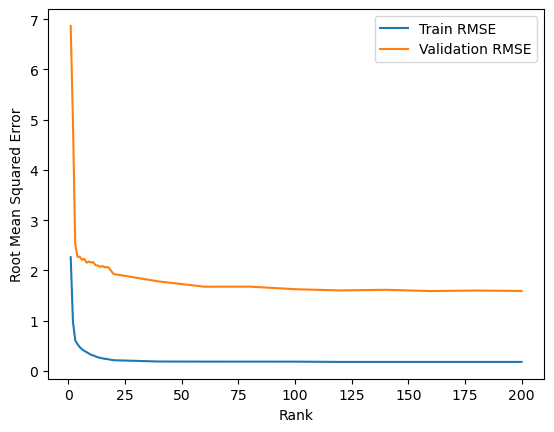

In [14]:
ranks = list(range(1,20)) + list(range(20, 201, 20))
fig, ax = plt.subplots()
ax.plot(ranks, train_rmses, label='Train RMSE')
ax.plot(ranks, val_rmses, label='Validation RMSE')

plt.xlabel('Rank')
plt.ylabel('Root Mean Squared Error')
plt.legend()

# ** Part 4: Topic modeling for text reviews **

In this section, we will build and examine a Bayesian topic model named [Latent Dirichlet Allocation (LDA)](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation). The goal of textual topic modeling is to discover latent topics whose mixtures generate textual documents through a stylized probabilistic generatve model. The topics often have semantic meaning. They may be associated with various aspects discussed in the text corpus such as politics, health, education, etc. Topic models are unsupervised machine learning algorithms. Hence, the nature of discovered topics is entirely dependent of the context of your dataset.

In [18]:
from pyspark.mllib.linalg import Vectors, DenseVector, SparseVector
from pyspark.mllib.clustering import LDA, LDAModel

** Question1: ** Let us create a new RDD of just textual reviews from reviews_rdd, obtain word counts, and build a list of unique words that do not include stop words. Use num_stop_words as a measure of how many of the most frequent words to filter out.

In [21]:
# TODO: Replace <FILL IN>

# number of stopwords i.e. most frequent words to remove
# removal of stopwords such as a, the, from, etc. that occur across a vast majority of documents improves topic models
import re
num_stop_words = 1000

all_reviews = reviews_rdd.map(lambda x : re.sub('[^a-zA-Z0-9\s]+', '', x['text']))
word_counts = list(all_reviews.flatMap(lambda x: x.lower().split()).map(lambda x: (x,1)).countByKey().items())
# sort words in descending order of frequency
word_counts = sorted(word_counts, key=lambda x:-x[1]) 

# remove stopwords
unique_words = [x[0] for x in word_counts[num_stop_words:]]
num_unique_words = len(unique_words)
print('Number of unique words: ', num_unique_words)

Number of unique words:  88020


** Question2: ** We will now construct two dictionaries - one which maps from each word to a unique integer index and the second one which maps back from the index to the word. Write the code required to do this.

In [22]:
# TODO: Replace <FILL IN>

word_to_index_dict = {unique_words[i]:i for i in range(len(unique_words))}
index_to_word_dict = {i:unique_words[i] for i in range(len(unique_words))}

** Question3: ** Construct an RDD of SparseVectors. Each SparseVector is built using the word counts of a review. Hence, the RDD of SparseVectors should be obtained as a map from the RDD of document word counts.

In [23]:
# TODO: Replace <FILL IN>
from collections import Counter

doc_vectors = all_reviews.map(lambda x: x.lower().split()).map(lambda x: [word_to_index_dict[w] for w in x if w in word_to_index_dict])
doc_vectors = doc_vectors.map(lambda x:SparseVector(num_unique_words,dict(Counter(x))))
# zipWithIndex result needs a minor transform to be acceptable to the LDA training procedure
doc_vectors = doc_vectors.zipWithIndex().map(lambda x: [x[1], x[0]])
print(doc_vectors.count())
print(doc_vectors.take(2))

62608
[[0, SparseVector(88020, {77: 1.0, 626: 1.0, 630: 1.0, 1069: 1.0, 1530: 1.0, 1982: 1.0, 2057: 1.0, 2096: 1.0, 2153: 1.0, 2188: 1.0, 2344: 1.0, 2465: 1.0, 3172: 1.0, 3376: 1.0, 3955: 1.0, 5576: 1.0, 6785: 2.0, 8124: 1.0, 8322: 1.0, 12532: 1.0, 38816: 1.0, 38817: 1.0, 38818: 1.0})], [1, SparseVector(88020, {1069: 1.0, 1824: 1.0, 2355: 1.0, 2962: 1.0, 3532: 1.0, 5431: 1.0, 5499: 1.0, 6257: 1.0})]]


** Question4: ** Train an LDA model with a 100 topics and the random seed set to 42.

In [24]:
# TODO: Replace <FILL IN>

lda_model = LDA.train(doc_vectors,k=100,seed=42)

** Question5: ** Display the LDA model vocabulary size.

In [25]:
# TODO: Replace <FILL IN>

print('Model vocabulary size: ', lda_model.vocabSize())

Model vocabulary size:  88020


** Question6: ** Display 5 learned topics and the top 100 terms that appear in each of these topics. Assign a semantic label/meaning to each of them (e.g. food, ambience, drinks, service, etc.) You can access the topic matrix using the function topicsMatrix on the model. Do the topics learned from Yelp reviews look representative of the corpus?

In [38]:
# TODO: Replace <FILL IN>

topic_matrix = lda_model.topicsMatrix()
topics=[0,30,60,90,99]
words=[]
for i in topics:
    rank=topic_matrix[i].argsort()[-100:][::-1]
    words.append([unique_words[j] for j in rank])

names=['food','location','service','snack','environment']
for i in range(5):
    print (i+1,'Topic:', names[i])
    print (words[i])
    print ()

1 Topic: food
['apparently', 'credit', 'sports', 'banana', 'pitt', 'basil', 'value', 'smaller', 'covered', 'thanks', 'shopping', 'shot', 'school', 'stayed', 'club', 'rating', 'theyve', 'walls', 'conversation', 'youd', 'healthy', 'mushroom', 'obviously', 'appreciate', 'pleased', 'classic', 'cakes', 'interior', 'modern', 'ribs', 'attention', 'sugar', 'penn', 'squirrel', 'heart', 'sad', 'slice', 'watching', 'salon', '45', 'hostess', 'beat', 'write', 'changed', 'original', 'normally', 'texture', 'bathroom', 'matter', 'favorites', 'book', 'fruit', 'waffle', 'pumpkin', 'horrible', 'disappointing', 'fat', 'avoid', 'quiet', 'expectations', 'lack', 'craving', 'bean', 'personal', 'draft', 'difficult', 'takeout', 'item', 'folks', 'strong', 'juicy', 'nearby', 'clearly', 'move', 'milk', 'play', 'glasses', 'usual', 'yeah', 'pizzas', 'casual', 'total', 'somewhat', 'heavy', 'n', 'wedding', 'alone', 'thinking', 'plain', 'chain', 'company', 'gem', 'touch', 'dirty', 'pulled', 'included', 'class', 'genera

Topics learned from Yelp looks representative of the corpus when we see the tops words are related to food and services. But since topic modelling is unsupervised, what each topic means is not that easy for us to learn about. And other general topics may not appear in the dataset due to the text reviews we have are limited.

# ** Part 5: Word2Vec for text reviews **

In this section, we will fit a [Word2Vec](https://en.wikipedia.org/wiki/Word2vec) model to the Yelp reviews text. Word2Vec is a popular model for embedding words in Euclidean space so they can be analyzed similar to real-valued vectors. Contrary to popular belief, Word2Vec models are not deep neural models. Inspite of being shallow neural networks, they capture word associations and analogies remarkably well. 

In [8]:
from pyspark.mllib.feature import Word2Vec
import re
pattern = re.compile('[\W_]+')

In [9]:
review_docs = reviews_rdd.map(lambda x : x['text'].lower().split())
review_docs = review_docs.map(lambda x : [pattern.sub('', w) for w in x])
print(review_docs.take(2))

[['thank', 'you', 'rob', 'i', 'truly', 'appreciated', 'all', 'the', 'help', 'i', 'received', 'from', 'this', 'agent', 'today', 'who', 'was', 'able', 'to', 'removed', 'the', 'extra', 'charges', 'on', 'my', 'bill', 'that', 'the', 'pasadena', 'verizon', 'store', 'on', 'lake', 'was', 'charging', 'me', 'on', 'my', 'bill', 'for', 'upgrading', 'my', 'phone', 'when', 'i', 'went', 'in', 'i', 'was', 'having', 'problems', 'with', 'my', 'blacberry', 'and', 'had', 'to', 'switch', 'to', 'the', 'iphone', 'last', 'week', 'rob', 'from', 'the', 'pennsylvania', 'store', 'who', 'i', 'was', 'connected', 'today', 'was', 'able', 'to', 'look', 'at', 'my', 'bill', 'and', 'all', 'the', 'notes', 'and', 'correct', 'the', 'problem', 'immediately', 'great', 'customer', 'service', 'he', 'even', 'set', 'up', 'a', 'follow', 'up', 'phone', 'call', 'with', 'me', 'on', 'july', '5th', 'to', 'make', 'sure', 'the', 'credit', 'goes', 'through', 'on', 'my', 'billi', 'cant', 'thank', 'him', 'enough'], ['after', 'waiting', 'for

** Question1: ** Fit a Word2Vec model to the review_docs RDD. Set the size of embedding vectors to 10, the random seed to 42, and the number of iterations to 10.

In [13]:
# TODO: Replace <FILL IN>

word2vec_model = Word2Vec().setVectorSize(10).setSeed(42).setNumIterations(10).fit(review_docs)

23/05/01 11:18:03 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
23/05/01 11:18:03 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


Let's us examine what words are closely associated with some example words. Run the cell below to see word associations. Feel free to add any additional words whose results you find interesting, but do not delete any of the words already in the list.

In [14]:
for word in ['salt', 'pepper', 'restaurant', 'italian', 'indian', 'chinese', 'direction', 'pittsburgh', 'burgh', 'city', 'location', 'cmu', 'pizza']:
    syms = word2vec_model.findSynonyms(word, 5)
    print('Words most similar to ', word, ' : ', [s[0] for s in syms])

Words most similar to  salt  :  ['sweetened', 'sugar', 'goodness', 'sourness', 'grain']
Words most similar to  pepper  :  ['ranch', 'celery', 'jalapeno', 'mustard', 'buttered']
Words most similar to  restaurant  :  ['resturant', 'keeper', 'osteria', 'location', 'restaraunt']
Words most similar to  italian  :  ['style', 'homestyle', 'steves', 'greek', 'shacks']
Words most similar to  indian  :  ['mexican', 'chinese', 'fastcasual', 'japanese', 'cuisine']
Words most similar to  chinese  :  ['mexican', 'indian', 'japanese', 'fastcasual', 'perfectta']
Words most similar to  direction  :  ['driveway', 'fly', 'terror', 'greyhound', 'swinging']
Words most similar to  pittsburgh  :  ['pgh', 'bloomfield', 'connecticut', 'burgh', 'korea']
Words most similar to  burgh  :  ['city', 'orlando', 'lebanon', 'berlin', 'midwest']
Words most similar to  city  :  ['brookline', 'newest', 'burgh', 'hiptique', 'district']
Words most similar to  location  :  ['scene', 'neighborhood', 'restaurantbar', 'landmark

** Question2: ** What "synonyms" in the result above give rise to perfect analogies? Are there words in the result that are spurious and not good substitutes for the originally supplied word?

** Answer: ** For example, pgh is the abbreviation of pittsburgh. CMU is the college and has the campus. City is close to burgh and district. These are all good analogies. But there are words that are not good substitutes. Goodness has less relationship with pepper and pittsburgh is less related to korea. 

# ** Part 6: Frequent pattern mining using FP-Growth algorithm **

In this section, we will mine frequent subsets of items that appear together in datapoints. This type of analysis is also known as frequent itemset mining or market basket analysis. Since the tags associated with Yelp businesses are sets, we can use them to carry out the frequent item set mining by employing the FP-Growth algorithm available in Spark.

In [15]:
from pyspark.mllib.fpm import FPGrowth

** Question1: ** Fill in the required code to perform itemset mining on business categories represented as an RDD of sets. Train the FP-Growth algorithm with a minimum support parameter of 0.01 and 10 partitions.

In [16]:
# TODO: Replace <FILL IN>

business_categories = businesses_rdd.map(lambda x:x['categories'])

fpgrowth_model = FPGrowth.train(business_categories, minSupport=0.01, numPartitions=10)
result = sorted(fpgrowth_model.freqItemsets().collect(), key=lambda x: -x[1])
for fi in result:
    if len(fi[0]) > 1:
        print(fi)

23/05/01 11:38:16 WARN FPGrowth: Input data is not cached.


FreqItemset(items=['Bars', 'Nightlife'], freq=3628)
FreqItemset(items=['Fashion', 'Shopping'], freq=2566)
FreqItemset(items=['Fast Food', 'Restaurants'], freq=2383)
FreqItemset(items=['Pizza', 'Restaurants'], freq=2223)
FreqItemset(items=['Mexican', 'Restaurants'], freq=2208)
FreqItemset(items=['American (Traditional)', 'Restaurants'], freq=2113)
FreqItemset(items=['Nightlife', 'Restaurants'], freq=2045)
FreqItemset(items=['Sandwiches', 'Restaurants'], freq=1981)
FreqItemset(items=['Bars', 'Nightlife', 'Restaurants'], freq=1934)
FreqItemset(items=['Bars', 'Restaurants'], freq=1934)
FreqItemset(items=['Coffee & Tea', 'Food'], freq=1890)
FreqItemset(items=['Food', 'Restaurants'], freq=1807)
FreqItemset(items=['Italian', 'Restaurants'], freq=1633)
FreqItemset(items=['Chinese', 'Restaurants'], freq=1496)
FreqItemset(items=['American (New)', 'Restaurants'], freq=1494)
FreqItemset(items=['Burgers', 'Restaurants'], freq=1481)
FreqItemset(items=['Hair Salons', 'Beauty & Spas'], freq=1388)
Freq

** Question2: ** Fill in the required code to perform itemset mining on business categories represented as an RDD of sets. Train the FP-Growth algorithm with a minimum support parameter of 0.001 and 10 partitions.

In [17]:
# TODO: Replace <FILL IN>

fpgrowth_model = FPGrowth.train(business_categories, minSupport=0.001, numPartitions=10)
result = sorted(fpgrowth_model.freqItemsets().collect(), key=lambda x: -x[1])
for fi in result:
    if len(fi[0]) > 1:
        print(fi)

23/05/01 11:39:39 WARN FPGrowth: Input data is not cached.


FreqItemset(items=['Bars', 'Nightlife'], freq=3628)
FreqItemset(items=['Fashion', 'Shopping'], freq=2566)
FreqItemset(items=['Fast Food', 'Restaurants'], freq=2383)
FreqItemset(items=['Pizza', 'Restaurants'], freq=2223)
FreqItemset(items=['Mexican', 'Restaurants'], freq=2208)
FreqItemset(items=['American (Traditional)', 'Restaurants'], freq=2113)
FreqItemset(items=['Nightlife', 'Restaurants'], freq=2045)
FreqItemset(items=['Sandwiches', 'Restaurants'], freq=1981)
FreqItemset(items=['Bars', 'Nightlife', 'Restaurants'], freq=1934)
FreqItemset(items=['Bars', 'Restaurants'], freq=1934)
FreqItemset(items=['Coffee & Tea', 'Food'], freq=1890)
FreqItemset(items=['Food', 'Restaurants'], freq=1807)
FreqItemset(items=['Italian', 'Restaurants'], freq=1633)
FreqItemset(items=['Chinese', 'Restaurants'], freq=1496)
FreqItemset(items=['American (New)', 'Restaurants'], freq=1494)
FreqItemset(items=['Burgers', 'Restaurants'], freq=1481)
FreqItemset(items=['Hair Salons', 'Beauty & Spas'], freq=1388)
Freq

** Question3: ** Are all the itemsets obtained by setting minimum support 0.01 included in the itemsets obtained when we set the minimum support to 0.001?

** Answer: ** Yes. All the itemsets obtained by setting minimum support 0.01 are included in the itemsets obtained when we set the minimum support to 0.001.